This notebook is used to build the models and use them to predict the IT Group for a ticket in Jira for the ITAI-2277 AI Capstone course.

Created by: Adam Blank\
Professor: Zohaib Khawaja\
Fall 2024


Here we will work on gathering the data using the Jira API to build our CSV with a larger dataset.

This section defines the connection to Jira, and connection success

In [1]:
import requests
import json
import pandas as pd
from tqdm import tqdm
import os
from dotenv import load_dotenv  # Add python-dotenv for better env management

load_dotenv()
BEARER_TOKEN = os.getenv('JIRA_BEARER_TOKEN')
JIRA_URL = os.getenv('JIRA_URL')
 
session = requests.Session()
session.headers.update({
    'Authorization': f'Bearer {BEARER_TOKEN}',
    'Content-Type': 'application/json'  # Ensure Content-Type is set to application/json
    })

def login_to_jira():
    response = session.get(JIRA_URL + '/rest/api/2/user?username=SVC_IT_Automation')
    
    if response.status_code == 200:
        print("Successfully logged in to Jira")
        #print(response.json())
        return True
    else:
        print("Failed to log in to Jira")
        print(response.status_code, response.text)
        return False


# Login to JIRA
if not login_to_jira():
    raise Exception("Failed to log in to JIRA")

Successfully logged in to Jira


Here we retrieve the data from Jira and store it in a dataframe.  We are collecting one year of closed tickets for the 29-IT Service Desk project.  This will provide a large dataset for our model to train on, and will take approximatley a half hour to complete.

In [2]:
# Data retrieval variables
start_at = 0
max_results = 500
total = None
fields = ['key', 'project', 'summary', 'description', 'assignee', 'httpUrl', 'customfield_19900', 'customfield_15404', 'customfield_14201']
issues_list = []

# Prepare for progress bar
pbar = tqdm(total=None)  # Total will be updated after first response

# Main loop for data retrieval
while total is None or start_at < total:
    search_data = {
        'jql': "project='29-IT Service Desk' AND status=closed AND created >= startOfYear(-1y)",
        'fields': fields,
        'startAt': start_at,
        'maxResults': max_results
    }

    search_response = session.post(
        f"{JIRA_URL}/rest/api/2/search",
        data=json.dumps(search_data),
        timeout=300
    )

    if search_response.status_code == 200:
        search_result = search_response.json()
        if 'issues' in search_result:
            issues_list.extend(search_result['issues'])

        if total is None:
            total = search_result['total']
            pbar.total = total // max_results + (total % max_results > 0)
            pbar.refresh()

        start_at += max_results
        pbar.update(1)

    elif search_response.status_code == 401:
        if not login_to_jira():
            print("Failed to re-authenticate.")
            break

    else:
        print("Received unexpected status code:", search_response.status_code)
        print(search_response.text)
        break

pbar.close()

# Convert collected data to DataFrame
df = pd.json_normalize(issues_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [37:08<00:00,  3.42s/it]


We'll save the dataframe to a CSV so that we have a saved copy incase something happens so we don't have to redownload it again.

In [3]:
# Save DataFrame to CSV
df.to_csv(f'dataframe.csv', index=False)

Lets look at the size and a sample of our dataframe we'll be working with

In [4]:
size = len(df)
print(f"Dataframe Size: {size:.2f}KB")

print(df.columns)
print(df.sample(5))

Dataframe Size: 325620.00KB
Index(['expand', 'id', 'self', 'key', 'fields.summary',
       'fields.customfield_14201', 'fields.description', 'fields.project.self',
       'fields.project.id', 'fields.project.key', 'fields.project.name',
       'fields.project.projectTypeKey', 'fields.project.avatarUrls.48x48',
       'fields.project.avatarUrls.24x24', 'fields.project.avatarUrls.16x16',
       'fields.project.avatarUrls.32x32',
       'fields.project.projectCategory.self',
       'fields.project.projectCategory.id',
       'fields.project.projectCategory.description',
       'fields.project.projectCategory.name', 'fields.assignee.self',
       'fields.assignee.name', 'fields.assignee.key',
       'fields.assignee.emailAddress', 'fields.assignee.avatarUrls.48x48',
       'fields.assignee.avatarUrls.24x24', 'fields.assignee.avatarUrls.16x16',
       'fields.assignee.avatarUrls.32x32', 'fields.assignee.displayName',
       'fields.assignee.active', 'fields.assignee.timeZone',
       'field

Verify GPU is available for use.


In [5]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Set device to the first CUDA device
    device = torch.device("cuda:0")
    print(f"Using device: {torch.cuda.get_device_name(0)}")

    # Create random tensors
    x = torch.randn(5000, 5000, device=device)
    y = torch.randn(5000, 5000, device=device)

    # Perform matrix multiplication
    print("Performing matrix multiplication on GPU...")
    z = torch.matmul(x, y)

    # The operation is performed on the GPU, so if this script runs without errors
    # and you observe the GPU utilization go up in your system's resource monitor,
    # then the Nvidia A1000 is being used.
    print("Done with matrix multiplication.")

else:
    print("CUDA is not available. Using CPU instead.")


Using device: NVIDIA GeForce RTX 3090
Performing matrix multiplication on GPU...
Done with matrix multiplication.


This cell is used to reload the dataframe from the CSV.  If we have already downloaded the data, we can skip the process of downloading.

In [1]:
import pandas as pd
# Load CSV
df = pd.read_csv('dataframe.csv')
print(len(df),'rows')

325620 rows


We will cleanup and remove unneeded columns to make it easier to work with, and reduce the size of the dataframe.

In [2]:
# Remove unneeded columns
df = df[[
    'fields.customfield_14201',
    'fields.assignee.displayName',
    'fields.customfield_15404.value',
    'fields.summary',
    'fields.description'
]]

We need to rename the columns to make it more easily understandable

In [3]:
df = df.rename(columns={
    'fields.customfield_14201':'Category 1',
    'fields.assignee.displayName':'Assignee',
    'fields.customfield_15404.value':'IT Group',
    'fields.summary':'Summary',
    'fields.description':'Description'
})

# Data Cleaning
Here we will clean the data to remove any unneeded characters, numbers, or stopwords using NLTK.

In [4]:
import nltk
from nltk.corpus import stopwords
import re

# Download only stopwords if needed
nltk.download('stopwords')

def clean_text(text):
    if not isinstance(text, str):
        return ''
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Remove stopwords - using simple split() instead of word_tokenize
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join([w for w in words if w not in stop_words])
    
    return text

# Clean Summary and Description fields
df['Summary'] = df['Summary'].apply(clean_text)
df['Description'] = df['Description'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Take a look at the dataframe to make sure it looks good.

In [5]:
print(df.columns)
print(df.sample(5))

Index(['Category 1', 'Assignee', 'IT Group', 'Summary', 'Description'], dtype='object')
                                               Category 1  \
28288   [{'self': 'https://csc.cioxhealth.com/rest/api...   
298511  [{'self': 'https://csc.cioxhealth.com/rest/api...   
128709  [{'self': 'https://csc.cioxhealth.com/rest/api...   
184384  [{'self': 'https://csc.cioxhealth.com/rest/api...   
209416  [{'self': 'https://csc.cioxhealth.com/rest/api...   

                     Assignee         IT Group  \
28288   Schawntae Birk-Earley  HealthSource CX   
298511             Adam Blank             M365   
128709    Shuriya Palanikumar        App- CDAI   
184384          Cheryl Bruner          Telecom   
209416        Byron Brown [X]              DTO   

                                                  Summary  \
28288                                    hspassword reset   
298511                               email address change   
128709  aetna mra ml arro update userdefinednumber pro...   


Additional pre-processing, removing all NaN rows as well as all ITSD rows so only properly assigned, closed tickets are in place.

In [6]:
#drop all rows with IT Group = NaN
df = df.dropna(subset=['IT Group'])

#drop all ITSD tickets
df = df[df['IT Group'] != 'ITSD']

Analyze Class Distribution to see how many tickets are in each IT Group.

Class distribution:
IT Group
Product Support (PS)           34762
DTO                            30405
DCO                            18489
Request Fulfillment            16931
App- Corp Systems               9082
App- CDAI                       8415
HealthSource CX                 7236
ReChase                         5421
App- CRI                        4839
M365                            4244
Digital Grid                    2580
Telecom                         2437
SOC                             1864
IAM                             1621
IT Software Licensing           1366
NETWORK                         1339
EUS                              909
Enterprise Tools                 866
BI Reporting CDAI                842
Virtualization                   638
App-SmartRequest/Record Hub      631
DBA                              606
Infra Engineering                486
Business Intelligence CRI        444
Desktop Engineering              150
Healthcare Integration           122
CorpSys -

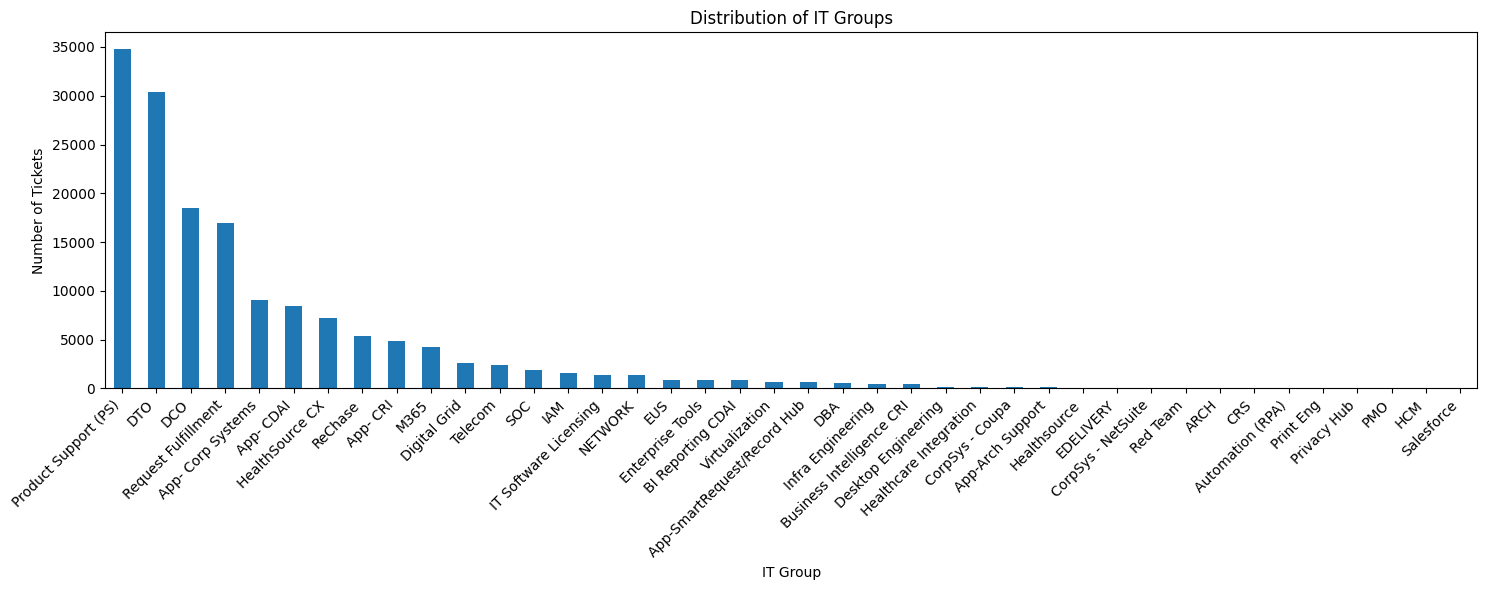

In [7]:
# Analyze class distribution
print("Class distribution:")
print(df['IT Group'].value_counts())
print("\nPercentage distribution:")
print(df['IT Group'].value_counts(normalize=True) * 100)

# Visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
df['IT Group'].value_counts().plot(kind='bar')
plt.title('Distribution of IT Groups')
plt.xlabel('IT Group')
plt.ylabel('Number of Tickets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Because there is such a large imbalance, lets normalize the data.  We will remove any IT Group that has less than 500 tickets, and then balance the rest to 500 tickets.

In [8]:
print("\nCreating balanced dataset for baseline model...")
group_counts = df['IT Group'].value_counts()
min_acceptable_samples = 500
print(f"\nOriginal class distribution:")
print(group_counts)

valid_groups = group_counts[group_counts >= min_acceptable_samples].index
df_filtered = df[df['IT Group'].isin(valid_groups)]
print(f"\nRemoved {len(group_counts) - len(valid_groups)} classes with fewer than {min_acceptable_samples} samples")

balanced_dfs = []
samples_per_class = min_acceptable_samples
for group in valid_groups:
    group_df = df_filtered[df_filtered['IT Group'] == group]
    if len(group_df) < samples_per_class * 1.5:
        n_samples = int(len(group_df) * 0.8)
    else:
        n_samples = samples_per_class
    sampled_df = group_df.sample(n=n_samples, random_state=42)
    balanced_dfs.append(sampled_df)

df_balanced = pd.concat(balanced_dfs, ignore_index=True)

print("\nFinal balanced dataset statistics:")
print(f"Total samples: {len(df_balanced)}")
print("\nSamples per class:")
print(df_balanced['IT Group'].value_counts())

df = df_balanced
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


Creating balanced dataset for baseline model...

Original class distribution:
IT Group
Product Support (PS)           34762
DTO                            30405
DCO                            18489
Request Fulfillment            16931
App- Corp Systems               9082
App- CDAI                       8415
HealthSource CX                 7236
ReChase                         5421
App- CRI                        4839
M365                            4244
Digital Grid                    2580
Telecom                         2437
SOC                             1864
IAM                             1621
IT Software Licensing           1366
NETWORK                         1339
EUS                              909
Enterprise Tools                 866
BI Reporting CDAI                842
Virtualization                   638
App-SmartRequest/Record Hub      631
DBA                              606
Infra Engineering                486
Business Intelligence CRI        444
Desktop Engineering     

Here we will continue our preprocessing.  We will combine the Summary and Description into one field to make it easier to work with.  We will also fill in any blank values with 'unknown'.  We will also create a label encoder for the IT Group field.

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

df['combined'] = df[['Summary', 'Description']].fillna('').agg(' '.join, axis=1)

imputer = SimpleImputer(strategy='constant', fill_value='unknown')
df[['IT Group', 'Assignee', 'Category 1']] = imputer.fit_transform(df[['IT Group', 'Assignee', 'Category 1']])

Now we will create the label encoders for the IT Group field and split the data into train and test sets.

In [10]:
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer



# Create and fit label encoders
le_it_group = LabelEncoder()
df['IT Group'] = le_it_group.fit_transform(df['IT Group'])
print("Label Encoders Completed")

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['combined'], df[['IT Group', 'Assignee']], test_size=0.2, random_state=42)

#TEST THISSSS
X_train, X_test, y_train, y_test = train_test_split(df['combined'], df[['IT Group']], test_size=0.2, random_state=42)

print("Train/Test split completed")




Label Encoders Completed
Train/Test split completed


# Model 1: LogisticRegression
Now we will create a grid search to find the best parameters for the LogisticRegression model.  We will use the GridSearchCV to find the best parameters.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Keep our existing TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.95,
    strip_accents='unicode',
    sublinear_tf=True
)

# Create base pipeline
base_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', LogisticRegression(
        n_jobs=-1,
        class_weight='balanced',
        random_state=42,
        max_iter=2000  # Increased from 1000 to 2000
    ))
])

# Modified parameter grid for LogisticRegression
param_grid = {
    'clf__C': [0.1, 1.0, 10.0],
    'clf__solver': ['saga'],  # Only using saga solver which supports both l1 and l2
    'clf__penalty': ['l2']    # Only using l2 penalty to avoid convergence issues
}

# Create and train grid search
grid_search = GridSearchCV(
    base_pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

print("Starting grid search...")
grid_search.fit(X_train, y_train['IT Group'])

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best model
pipeline_it_group = grid_search.best_estimator_

Starting grid search...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ......clf__C=0.1, clf__penalty=l2, clf__solver=saga; total time=   0.9s
[CV] END ......clf__C=0.1, clf__penalty=l2, clf__solver=saga; total time=   0.9s
[CV] END ......clf__C=0.1, clf__penalty=l2, clf__solver=saga; total time=   0.9s
[CV] END ......clf__C=1.0, clf__penalty=l2, clf__solver=saga; total time=   0.9s
[CV] END ......clf__C=1.0, clf__penalty=l2, clf__solver=saga; total time=   0.9s
[CV] END ......clf__C=1.0, clf__penalty=l2, clf__solver=saga; total time=   0.9s
[CV] END .....clf__C=10.0, clf__penalty=l2, clf__solver=saga; total time=   1.3s
[CV] END .....clf__C=10.0, clf__penalty=l2, clf__solver=saga; total time=   1.3s
[CV] END .....clf__C=10.0, clf__penalty=l2, clf__solver=saga; total time=   1.3s

Best parameters: {'clf__C': 10.0, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Best cross-validation score: 0.7433505869372791


# Model 2: RoBERTa
Here we will implement the RoBERTa model.  We will use the RobertaTokenizer and RobertaForSequenceClassification to create the model.  We will also use the AdamW optimizer and the DataLoader to create the dataset and train the model.  Finally we will save the model to disk.


In [17]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm.auto import tqdm 

# Initialize tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=len(le_it_group.classes_),  # Number of IT groups
    output_attentions=False,
    output_hidden_states=False,
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Create dataset class
class TicketDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts, truncation=True, padding=True, 
                                 max_length=max_length, return_tensors='pt')
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Prepare data
train_texts = X_train.tolist()
train_labels = y_train['IT Group'].tolist()  # Using encoded labels

# Create datasets
train_dataset = TicketDataset(train_texts, train_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Training configuration
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3

# Training loop
model.train()
for epoch in range(epochs):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}')
    
    for batch in progress_bar:
        optimizer.zero_grad()
        
        # Move batch to GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.3f}'})
    
    avg_loss = total_loss / len(train_loader)
    print(f'\nEpoch {epoch + 1} average loss: {avg_loss:.3f}')

# Add prediction function for RoBERTa
def predict_with_roberta(text):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        
        predicted_class = torch.argmax(probs, dim=-1).cpu().numpy()[0]
        confidence_score = probs.max().item()
        
        predicted_group = le_it_group.inverse_transform([predicted_class])[0]
        
        return predicted_group, confidence_score

# Save the model
model_name = 'roberta_classifier'
model_path = f'{model_name}_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Saved {model_name} model to {model_path}")


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████


Epoch 1 average loss: 1.507


Epoch 2:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                  | 438/1100 [01:22<02:01,  5.46it/s, loss=0.351]

[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=  13.1s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400; total time=   7.3s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200; total time=   2.9s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=  12.4s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300; total time=   9.9s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=   8.3s
[CV]

Epoch 2:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 440/1100 [01:22<02:01,  5.45it/s, loss=1.560]

[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=200; total time=   9.0s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300; total time=   8.1s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=400; total time=   5.8s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300; total time=   2.7s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=400; total time=  15.9s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300; total time=   7.2s
[CV]

Epoch 2:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 441/1100 [01:23<02:01,  5.44it/s, loss=1.800]

[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200; total time=   8.1s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200; total time=   8.1s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=   4.3s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200; total time=   2.6s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400; total time=   3.6s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200; total time=  13.4s
[CV]

Epoch 2:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 443/1100 [01:23<02:00,  5.46it/s, loss=0.263]

[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=  15.2s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400; total time=   5.6s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300; total time=   2.7s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=  15.0s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=400; total time=   9.7s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=300; total time=   8.3s
[CV]

Epoch 2:  40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                | 445/1100 [01:23<02:00,  5.45it/s, loss=1.177]

[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=400; total time=  16.6s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=   5.6s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=400; total time=   4.1s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=400; total time=  15.8s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300; total time=   7.3s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=400; total time=   8.2s
[CV]

Epoch 2:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 448/1100 [01:24<01:59,  5.45it/s, loss=1.688]

[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=400; total time=  16.7s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=   4.9s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=400; total time=   3.0s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=200; total time=  11.9s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300; total time=   9.4s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=  10.4s
[CV]

Epoch 2:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 449/1100 [01:24<01:59,  5.43it/s, loss=1.233]

[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200; total time=   8.6s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300; total time=   8.3s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=   5.2s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200; total time=   2.1s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=400; total time=  22.0s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=400; total time=  10.5s
[CV]

Epoch 2:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                              | 451/1100 [01:24<01:59,  5.41it/s, loss=1.475]

[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=  15.3s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=   4.0s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=400; total time=   4.4s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=  18.7s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400; total time=   8.7s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200; total time=   5.8s
[CV]

Epoch 2:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 452/1100 [01:25<01:59,  5.41it/s, loss=1.809]

[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=400; total time=  11.2s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=200; total time=   6.3s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=200; total time=   3.6s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=400; total time=   3.5s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=200; total time=  13.1s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=400; total time=  10.3s
[CV]

Epoch 2:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 454/1100 [01:25<01:59,  5.42it/s, loss=1.159]

[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=200; total time=   9.3s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=400; total time=   8.9s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=300; total time=   5.0s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=200; total time=  13.9s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300; total time=   8.5s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=  10.2s
[CV]

Epoch 2:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 489/1100 [01:32<01:53,  5.40it/s, loss=1.328]

[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=  15.3s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400; total time=   5.4s
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200; total time=   3.1s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=300; total time=  18.7s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=400; total time=   8.8s
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=200; total time=   6.0s
[CV]

Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1100/1100 [03:28<00:00,  5.28it/s, loss=0.967]



Epoch 2 average loss: 0.848


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1100/1100 [03:29<00:00,  5.24it/s, loss=0.762]



Epoch 3 average loss: 0.652
Saved roberta_classifier model to roberta_classifier_model.pth


Evaluate the RoBERTa Model.  We will use the classification_report, confusion_matrix, and accuracy_score to evaluate the model.  We will also use seaborn and matplotlib to plot the confusion matrix and accuracy vs confidence.

Evaluating RoBERTa model...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2200/2200 [00:15<00:00, 142.34it/s]



RoBERTa Model Evaluation Results:
Overall Accuracy: 0.7359

Classification Report:
                             precision    recall  f1-score   support

                  App- CDAI       0.80      0.94      0.86        96
                   App- CRI       0.54      0.58      0.56       110
          App- Corp Systems       0.69      0.77      0.73       111
App-SmartRequest/Record Hub       0.92      0.82      0.87       106
          BI Reporting CDAI       0.77      0.84      0.81        94
                        DBA       0.84      0.77      0.80        79
                        DCO       0.94      0.89      0.91       102
                        DTO       0.43      0.17      0.24        90
               Digital Grid       0.89      0.87      0.88       103
                        EUS       0.63      0.83      0.72        92
           Enterprise Tools       0.72      0.88      0.79       106
            HealthSource CX       0.55      0.49      0.52        93
                  

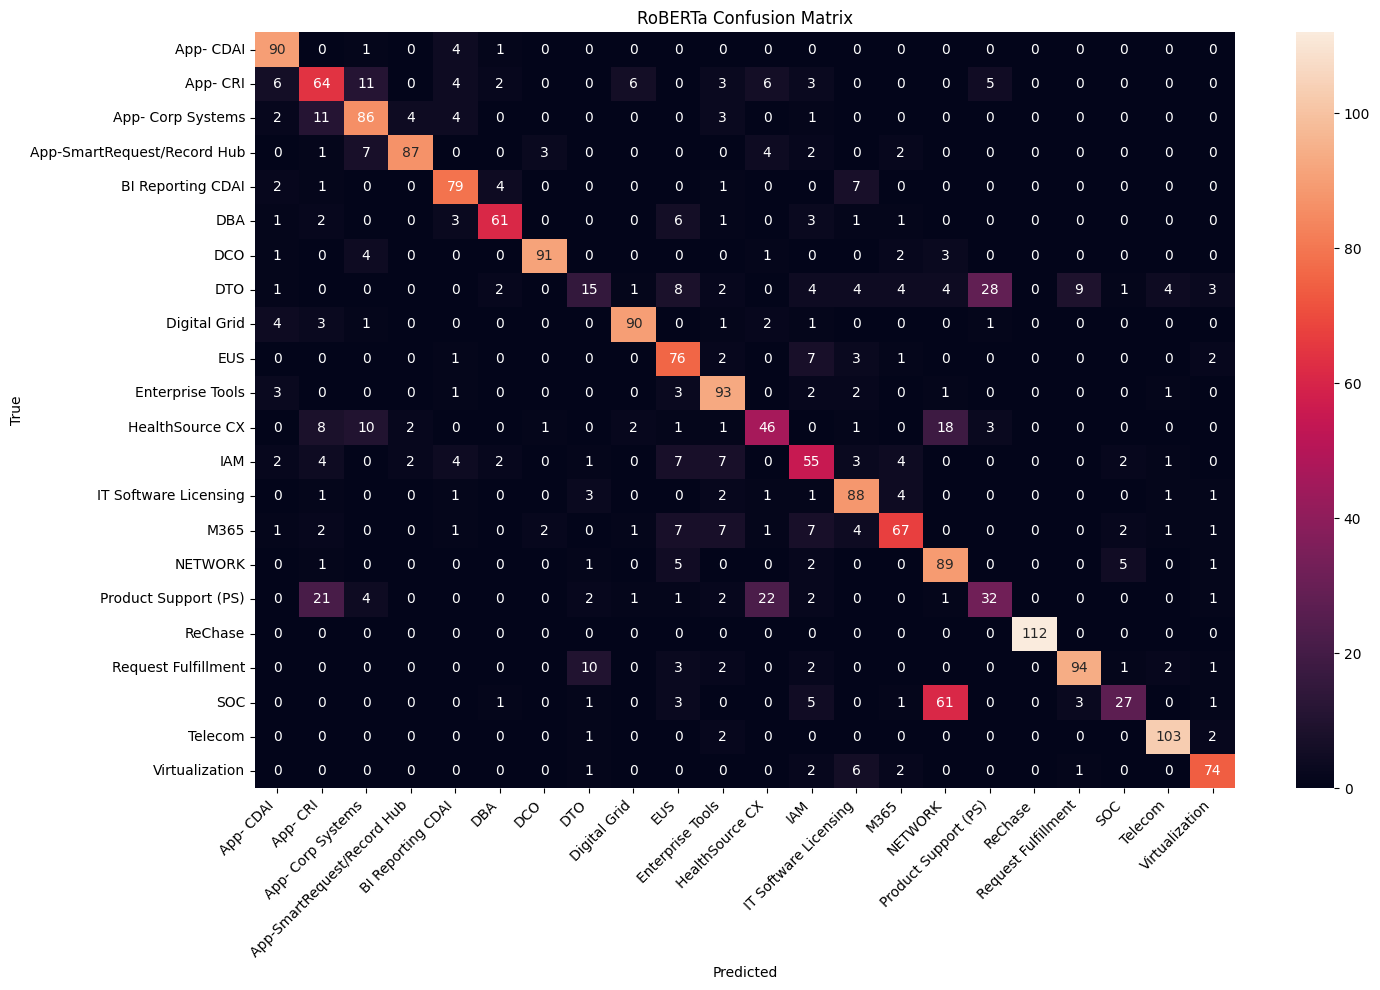

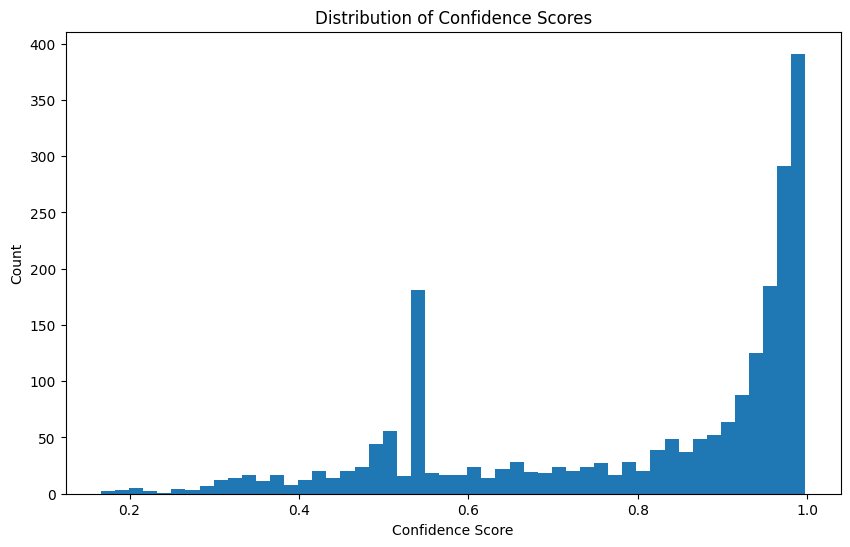

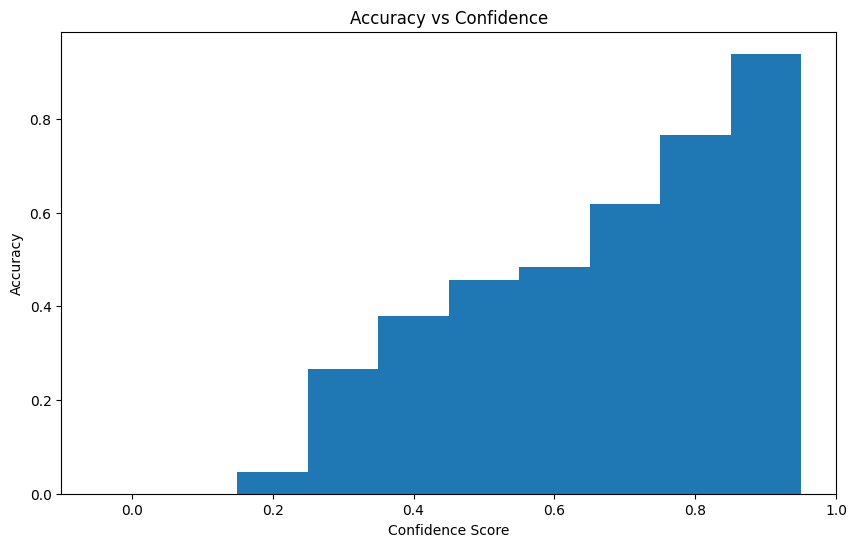


Model Comparison:
RoBERTa Accuracy: 0.7359
Random Forest Accuracy: 0.7086

Top misclassification patterns:
True: SOC                  Predicted: NETWORK              Count: 61
True: DTO                  Predicted: Product Support (PS) Count: 28
True: Product Support (PS) Predicted: HealthSource CX      Count: 22
True: Product Support (PS) Predicted: App- CRI             Count: 21
True: HealthSource CX      Predicted: NETWORK              Count: 18
True: App- Corp Systems    Predicted: App- CRI             Count: 11
True: App- CRI             Predicted: App- Corp Systems    Count: 11
True: Request Fulfillment  Predicted: DTO                  Count: 10
True: HealthSource CX      Predicted: App- Corp Systems    Count: 10
True: DTO                  Predicted: Request Fulfillment  Count: 9


In [18]:
# Evaluation of RoBERTa Model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_roberta():
    """
    Evaluate RoBERTa model performance on test set
    """
    model.eval()  # Set model to evaluation mode
    predictions = []
    true_labels = []
    confidence_scores = []
    
    # Create test dataset
    test_texts = X_test.tolist()
    test_labels = y_test['IT Group'].tolist()
    
    print("Evaluating RoBERTa model...")
    
    # Get predictions for test set
    with torch.no_grad():  # No gradients needed for evaluation
        for text, true_label in tqdm(zip(test_texts, test_labels), total=len(test_texts)):
            # Get prediction
            inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=-1)
            
            predicted_class = torch.argmax(probs, dim=-1).cpu().numpy()[0]
            confidence = probs.max().item()
            
            predictions.append(predicted_class)
            true_labels.append(true_label)
            confidence_scores.append(confidence)
    
    # Convert predictions back to group names
    predicted_groups = le_it_group.inverse_transform(predictions)
    true_groups = le_it_group.inverse_transform(true_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(true_groups, predicted_groups)
    class_report = classification_report(true_groups, predicted_groups)
    conf_matrix = confusion_matrix(true_groups, predicted_groups)
    
    # Print results
    print("\nRoBERTa Model Evaluation Results:")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    
    # Plot confusion matrix
    plt.figure(figsize=(15, 10))
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='d',
                xticklabels=le_it_group.classes_,
                yticklabels=le_it_group.classes_)
    plt.title('RoBERTa Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Analyze confidence distribution
    plt.figure(figsize=(10, 6))
    plt.hist(confidence_scores, bins=50)
    plt.title('Distribution of Confidence Scores')
    plt.xlabel('Confidence Score')
    plt.ylabel('Count')
    plt.show()
    
    # Analyze accuracy vs confidence
    confidence_bins = np.linspace(0, 1, 11)
    accuracies = []
    counts = []
    
    for i in range(len(confidence_bins)-1):
        mask = (np.array(confidence_scores) >= confidence_bins[i]) & (np.array(confidence_scores) < confidence_bins[i+1])
        if mask.sum() > 0:
            bin_acc = accuracy_score(np.array(true_groups)[mask], np.array(predicted_groups)[mask])
            accuracies.append(bin_acc)
            counts.append(mask.sum())
        else:
            accuracies.append(0)
            counts.append(0)
    
    plt.figure(figsize=(10, 6))
    plt.bar(confidence_bins[:-1], accuracies, width=0.1)
    plt.title('Accuracy vs Confidence')
    plt.xlabel('Confidence Score')
    plt.ylabel('Accuracy')
    plt.show()
    
    # Compare with Random Forest accuracy
    rf_predictions = pipeline_it_group.predict(X_test)
    rf_accuracy = accuracy_score(y_test['IT Group'], rf_predictions)
    
    print("\nModel Comparison:")
    print(f"RoBERTa Accuracy: {accuracy:.4f}")
    print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
    
    # Return metrics for further analysis if needed
    return {
        'accuracy': accuracy,
        'classification_report': class_report,
        'confusion_matrix': conf_matrix,
        'confidence_scores': confidence_scores,
        'predictions': predicted_groups,
        'true_labels': true_groups
    }

# Run evaluation
evaluation_results = evaluate_roberta()

# Additional analysis: Most common misclassifications
def analyze_misclassifications(true_labels, predictions, top_n=10):
    """
    Analyze the most common misclassifications
    """
    misclassifications = []
    for true, pred in zip(true_labels, predictions):
        if true != pred:
            misclassifications.append((true, pred))
    
    # Count misclassification patterns
    from collections import Counter
    misclass_counts = Counter(misclassifications)
    
    print("\nTop misclassification patterns:")
    for (true, pred), count in misclass_counts.most_common(top_n):
        print(f"True: {true:<20} Predicted: {pred:<20} Count: {count}")

# Analyze misclassifications
analyze_misclassifications(evaluation_results['true_labels'], 
                         evaluation_results['predictions'])



# Using the models to predict the IT Group for a ticket in Jira.

First we create a function to search for a ticket in Jira and return the IT Group

In [19]:
def search_jira_ticket(ticket_number):
    if not login_to_jira():
        raise Exception("Failed to log in to JIRA")

    search_data = {
        'jql': f"issue = {ticket_number}",
        'fields': ['summary', 'description', 'assignee', 'customfield_19900', 'customfield_15404', 'customfield_14201'],
        'startAt': 0,
        'maxResults': 1
    }

    search_response = session.post(
        f"{JIRA_URL}/rest/api/2/search",
        data=json.dumps(search_data),
        timeout=300
    )

    if search_response.status_code == 200:
        search_result = search_response.json()
        return pd.json_normalize(search_result['issues'])
    else:
        print("Failed to retrieve the ticket:", search_response.status_code)
        print(search_response.text)
        return None


Here is the function to validate and suggest the IT Group for a ticket in Jira.

In [20]:
def search_jira_unassigned_tickets_in_group(group_name):
    if not login_to_jira():
        raise Exception("Failed to log in to JIRA")
   
    # Modify the JQL query
    search_data = {
        'jql': f"project='29-IT Service Desk' AND 'IT Group' = '{group_name}' AND status != closed",
        'fields': ['key', 'summary', 'description', 'assignee', 'customfield_19900', 'customfield_15404', 'customfield_14201'],
        'startAt': 0,
        'maxResults': 100  # You can adjust the maxResults as needed
    }
   
    search_response = session.post(
        f"{JIRA_URL}/rest/api/2/search",
        data=json.dumps(search_data),
        timeout=300
    )
   
    if search_response.status_code == 200:
        search_result = search_response.json()
        return pd.json_normalize(search_result['issues'])
    else:
        print("Failed to retrieve tickets:", search_response.status_code)
        print(search_response.text)
        return None
   
# Example usage
group_name = "M365"
unassigned_tickets_df = search_jira_unassigned_tickets_in_group(group_name)
print(unassigned_tickets_df)

Successfully logged in to Jira
                                               expand       id  \
0   operations,versionedRepresentations,editmeta,c...  2250049   
1   operations,versionedRepresentations,editmeta,c...  2249841   
2   operations,versionedRepresentations,editmeta,c...  2249068   
3   operations,versionedRepresentations,editmeta,c...  2248541   
4   operations,versionedRepresentations,editmeta,c...  2248175   
..                                                ...      ...   
95  operations,versionedRepresentations,editmeta,c...  2167392   
96  operations,versionedRepresentations,editmeta,c...  2166488   
97  operations,versionedRepresentations,editmeta,c...  2164894   
98  operations,versionedRepresentations,editmeta,c...  2163979   
99  operations,versionedRepresentations,editmeta,c...  2161023   

                                                 self          key  \
0   https://csc.cioxhealth.com/rest/api/2/issue/22...  ITSD-772624   
1   https://csc.cioxhealth.com/rest/

Load RoBERTa Model from disk

In [21]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer
import torch

print("Loading saved model...")
model_name = 'roberta_classifier'
model_path = f'{model_name}_model.pth'
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=len(le_it_group.classes_),
    output_attentions=False,
    output_hidden_states=False,
).to(device)
model.load_state_dict(torch.load(model_path, weights_only=True))
print("Model loaded successfully")

# Verify the model is loaded correctly
print(f"Model type: {type(model)}")
print(f"Model device: {next(model.parameters()).device}")


Loading saved model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully
Model type: <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>
Model device: cuda:0


Finally we will create a function to predict the IT Group for a ticket in Jira.  This will use both the RandomForest and RoBERTa models to predict the IT Group.  Predictions will be combined and averaged to get a final prediction.  As well as determine if both models agree on the prediction.  We will also use the confidence score to determine if the prediction is confident enough to suggest a reassignment.

In [22]:
import torch.nn.functional as F
# First, let's check if the model is properly initialized
print(f"Model type: {type(model)}")
print(f"Is model on correct device: {next(model.parameters()).device}")

# Initialize tokenizer globally
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def predict_with_roberta(text):
    """Make predictions using the RoBERTa model"""
    try:
        model.eval()
        with torch.no_grad():
            inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=-1)
            
            predicted_class = torch.argmax(probs, dim=-1).cpu().numpy()[0]
            confidence_score = probs.max().item()
            
            predicted_group = le_it_group.inverse_transform([predicted_class])[0]
            
            return predicted_group, confidence_score
    except Exception as e:
        print(f"Detailed error in predict_with_roberta: {str(e)}")
        print(f"Model state: {model}")
        return None, 0.0
    

def validate_and_suggest_it_group_with_models(group_name, confidence_threshold=0.10):
    df_tickets = search_jira_unassigned_tickets_in_group(group_name)
    if df_tickets.empty:
        return "No tickets found or error in retrieval"

    suggestions = []
    print("\nAnalyzing predictions:")
    for index, row in df_tickets.iterrows():
        combined_text = f"{row['fields.summary']} {row['fields.description']}"
        ticket_url = f"https://csc.cioxhealth.com/browse/{row['key']}"
        
        # Get predictions from RandomForest and RoBERTa
        rf_pred_encoded = pipeline_it_group.predict([combined_text])[0]
        rf_pred = le_it_group.inverse_transform([rf_pred_encoded])[0]
        rf_prob = pipeline_it_group.predict_proba([combined_text]).max()
        
        roberta_result = predict_with_roberta(combined_text)
        if roberta_result[0] is None:
            continue
            
        roberta_pred, roberta_prob = roberta_result
        
        # Calculate average confidence
        avg_conf = (rf_prob + roberta_prob) / 2
        
        # Debug print for each ticket
        print(f"\nTicket {row['key']} - {ticket_url}")
        print(f"RandomForest: {rf_pred} (confidence: {rf_prob:.2f})")
        print(f"RoBERTa: {roberta_pred} (confidence: {roberta_prob:.2f})")
        print(f"Current Group: {group_name}")
        
        # Combine predictions
        predictions = {
            'RandomForest': (rf_pred, rf_prob),
            'RoBERTa': (roberta_pred, roberta_prob)
        }
        
        # Only suggest if both models agree on a different group
        if rf_pred == roberta_pred and rf_pred != group_name:
            if avg_conf > confidence_threshold:
                print("-> Models agree on different group")
                suggestions.append({
                    'Ticket': f"[{row['key']}](https://csc.cioxhealth.com/browse/{row['key']})",
                    'Current Group': group_name,
                    'Suggested Group': rf_pred,
                    'Confidence Score': avg_conf,
                    'Model Predictions': predictions
                })
            else:
                print(f"-> Models agree on different group but confidence ({avg_conf:.2f}) below threshold ({confidence_threshold})")
        else:
            if rf_pred != roberta_pred:
                print(f"-> Models disagree on prediction (avg confidence: {avg_conf:.2f})")
            else:
                print(f"-> Models agree on current group (avg confidence: {avg_conf:.2f})")
    
    return sorted(suggestions, key=lambda x: x['Confidence Score'], reverse=True)

# Example usage
group_name = "M365"
suggestions = validate_and_suggest_it_group_with_models(group_name)

if isinstance(suggestions, list):
    print("\nSuggestions for reassignment with confidence scores and links to JIRA, sorted by confidence:")
    for suggestion in suggestions:
        print(f"\nTicket {suggestion['Ticket']}")
        print(f"Current Group: {suggestion['Current Group']}")
        print(f"Suggested Group: {suggestion['Suggested Group']}")
        print(f"Confidence Score: {suggestion['Confidence Score']:.2f}")
        print("Model Predictions:")
        for model_name, (pred, conf) in suggestion['Model Predictions'].items():
            print(f"  {model_name}: {pred} (confidence: {conf:.2f})")
else:
    print(suggestions)


Model type: <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>
Is model on correct device: cuda:0
Successfully logged in to Jira

Analyzing predictions:

Ticket ITSD-772624 - https://csc.cioxhealth.com/browse/ITSD-772624
RandomForest: App- CRI (confidence: 0.06)
RoBERTa: M365 (confidence: 0.62)
Current Group: M365
-> Models disagree on prediction (avg confidence: 0.34)

Ticket ITSD-772533 - https://csc.cioxhealth.com/browse/ITSD-772533
RandomForest: M365 (confidence: 0.12)
RoBERTa: M365 (confidence: 0.94)
Current Group: M365
-> Models agree on current group (avg confidence: 0.53)

Ticket ITSD-772234 - https://csc.cioxhealth.com/browse/ITSD-772234
RandomForest: Request Fulfillment (confidence: 0.08)
RoBERTa: M365 (confidence: 0.64)
Current Group: M365
-> Models disagree on prediction (avg confidence: 0.36)

Ticket ITSD-771938 - https://csc.cioxhealth.com/browse/ITSD-771938
RandomForest: M365 (confidence: 0.08)
RoBERTa: M365 (confidence: 0.63)
Current